In [102]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
import sklearn.feature_selection as fs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Andrea's data analysis and exploration for HCC1806 SMARTS

In [40]:
unfilt_hcc_smarts = pd.read_csv("data/smartSeq/HCC1806_SmartS_Unfiltered_Data.txt", sep = " ")
meta_hcc_smarts = pd.read_table("data/smartSeq/HCC1806_SmartS_MetaData.tsv")

In [8]:
print(unfilt_hcc_smarts.head())

          output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam  \
WASH7P                                                    0                      
CICP27                                                    0                      
DDX11L17                                                  0                      
WASH9P                                                    0                      
OR4F29                                                    2                      

          output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam  \
WASH7P                                                    0                     
CICP27                                                    0                     
DDX11L17                                                  0                     
WASH9P                                                    0                     
OR4F29                                                    0                     

          output.STA

First we look at how the dataset is structured, to have a gist of the data.

The columns of the HCC1806 SmartSeq dataset represent the different cells from the cell line. They are 243 in total.

The rows of the HCC1806 SmartSeq dataset represent the different genes present in each cell and in what quantity. They are 23396 in total.

## How much data is null in the files?

In [35]:
print(unfilt_hcc_smarts.isnull().sum())
print(f"\nColumns with null data: {unfilt_hcc_smarts.columns[unfilt_hcc_smarts.isnull().any()].to_list()}")

output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        0
                                                                       ..
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    0
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      0
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     0
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     0
Length: 243, dtype: int64

Columns with null data: []


The number of columns with null data is: 0. As shown above.

## Outliers

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

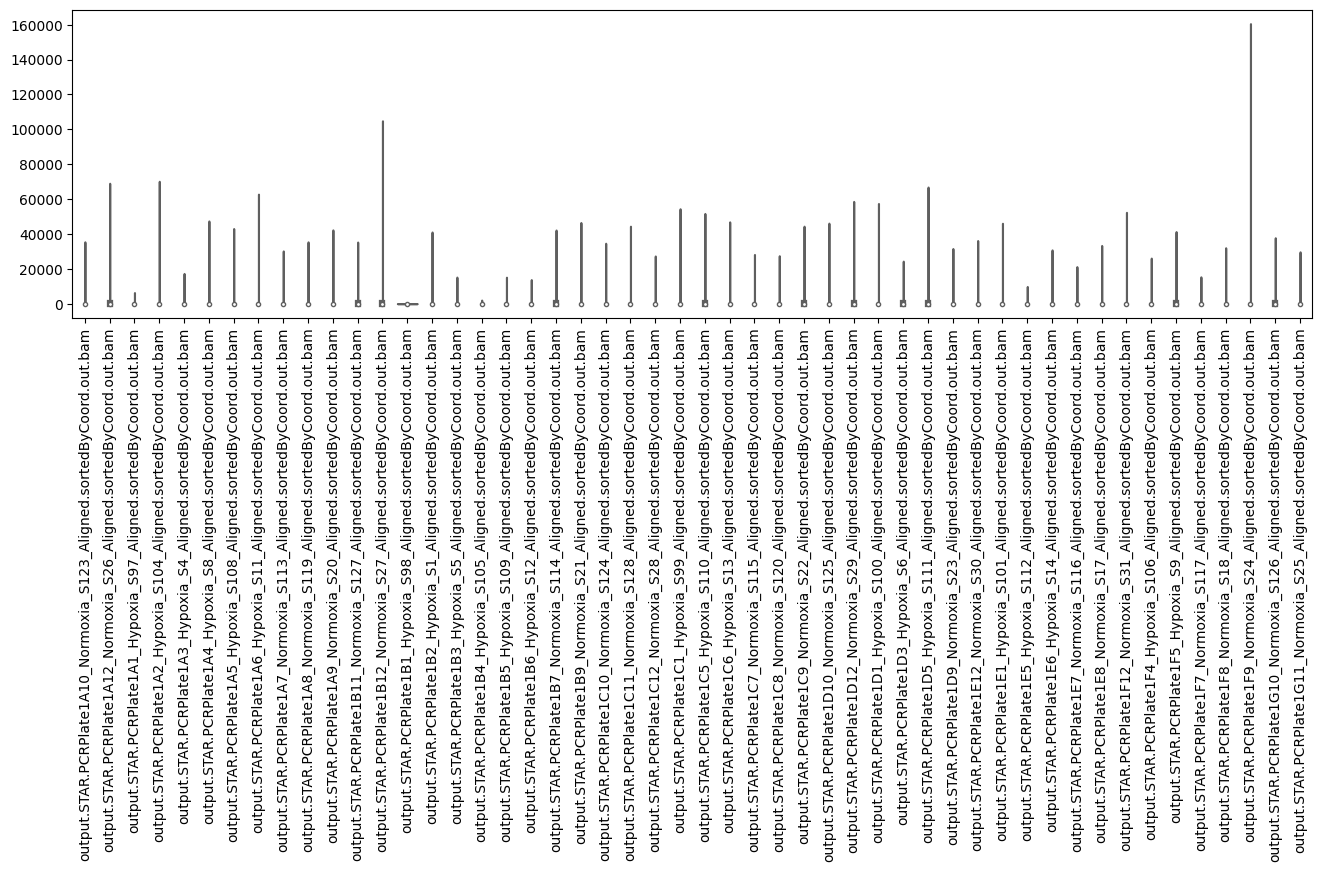

In [75]:
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=unfilt_hcc_smarts.iloc[:, :50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [70]:
no_out_hcc_smarts = unfilt_hcc_smarts[(np.abs(stats.zscore(unfilt_hcc_smarts)) < 3).all(axis=1)]
no_out_hcc_smarts

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
WASH7P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CICP27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDX11L17,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASH9P,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
OR4F29,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-TS2,5,29,0,17,0,0,14,1,1,5,...,4,4,0,5,1,17,1,6,3,3
MT-TL2,15,36,0,8,3,0,31,2,4,3,...,12,6,4,5,3,11,3,23,3,15
MT-TT,26,62,0,11,4,0,41,9,2,8,...,48,31,3,8,5,42,1,15,6,34
MT-TP,66,71,1,3,9,14,91,22,3,30,...,119,52,11,22,15,48,18,36,8,79


### We Remove all rows that have outliers in, at least, one column.
With the above outlier removal process, we only keep data in the middle 99.7% by removing all elements with a z-score > 3.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

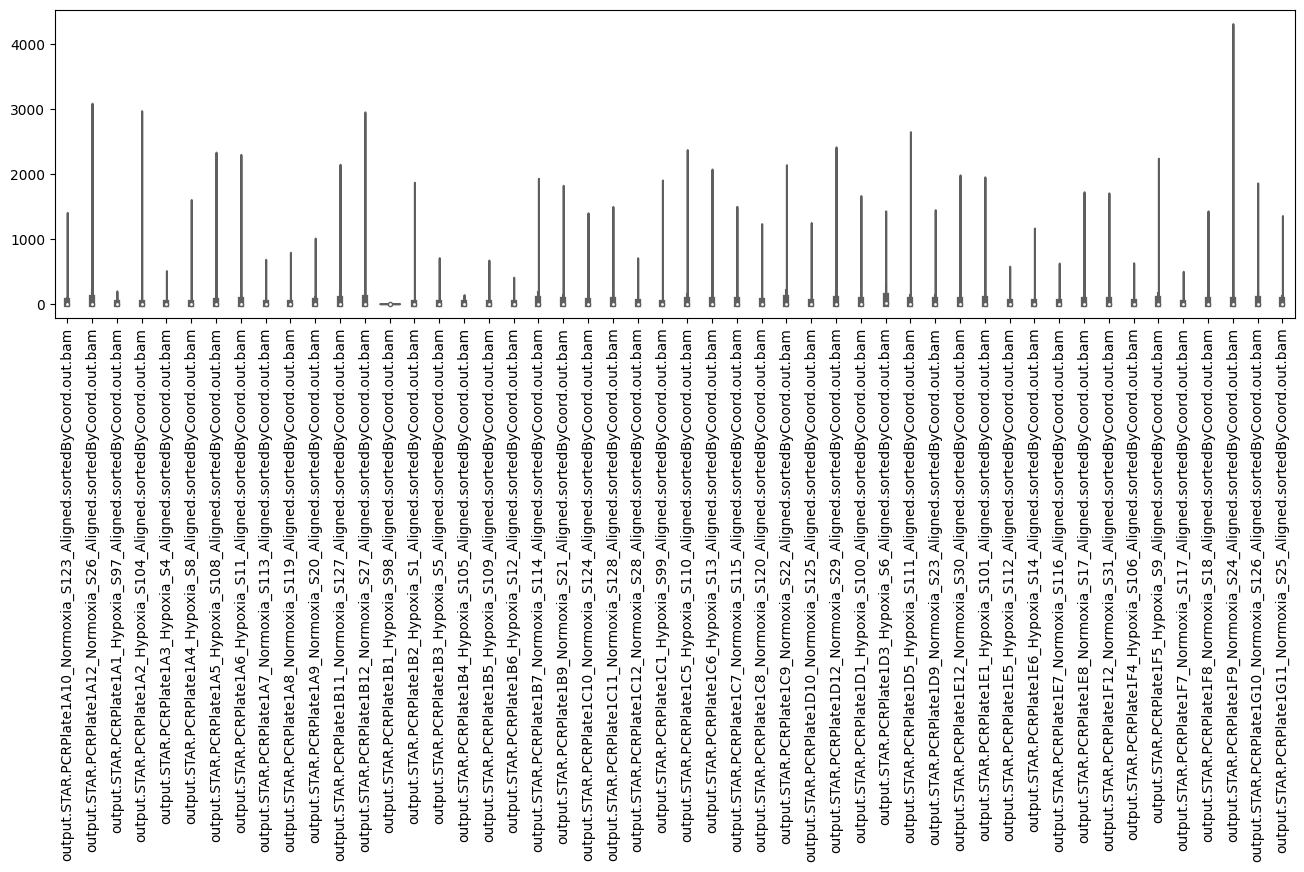

In [71]:
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=no_out_hcc_smarts.iloc[:, :50],palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

We can see that despite having removed outliers, the distribution of the data has not really changed. This can be attributed to the fact that most of the data is 0's and hence the true information is held by non-zero data (the dataframe is sparse).

We will discard the removal of outliers and use different methods of data cleaning.

## Data Normalisation

In [98]:
from fix_data import add_label_T

transposed_df = add_label_T(unfilt_hcc_smarts)
transposed_df.reset_index(drop=True)

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,label
0,0,0,0,0,2,250,54,1740,6,1,...,5,15,3852,900,22,4208,26,66,0,1
1,0,0,0,0,0,424,100,2340,5,1,...,29,36,7457,1439,43,6491,62,71,4,1
2,0,0,0,0,0,11,0,22,0,0,...,0,0,93,12,0,25,0,1,0,0
3,0,0,0,0,0,63,16,1020,3,0,...,17,8,1479,234,0,4819,11,3,7,0
4,0,0,0,0,0,27,3,303,0,0,...,0,3,303,33,0,310,4,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0,0,0,1,0,146,47,961,1,0,...,17,11,2926,423,26,3719,42,48,3,1
239,0,0,0,0,0,37,6,372,0,0,...,1,3,688,114,1,984,1,18,0,1
240,0,0,0,1,0,83,30,1128,4,0,...,6,23,2999,486,4,2256,15,36,2,0
241,0,0,0,0,0,47,7,258,1,0,...,3,3,611,75,4,981,6,8,1,1


In [99]:
target = transposed_df['label']
transposed_df.drop(["label"], axis=1, inplace=True)

In [100]:
# Instantiate VarianceThreshold object
threshold = 0.05
selector = fs.VarianceThreshold(threshold)

# Fit selector to DataFrame
selector.fit(transposed_df)

# Get boolean mask of features that meet threshold
mask = selector.get_support()

# Get list of column names that meet threshold
near_zero_var_cols = transposed_df.columns[~mask].tolist()

# Print the result
print(f'Columns with < {threshold} variance: {near_zero_var_cols}')
print(f"In total: {len(near_zero_var_cols)}")
var_fixed = transposed_df.drop(near_zero_var_cols, axis=1)
var_fixed

Columns with < 0.05 variance: ['CICP3', 'MIR6726', 'NDUFB4P8', 'MMP23A', 'RPL7P11', 'RPL23AP19', 'MZT1P1', 'LINC01647', 'DRAXIN', 'SBF1P2', 'HNRNPCL3', 'BRWD1P1', 'CELA2B', 'CLCNKA', 'RNU6-1099P', 'HSPE1P27', 'PPP1R11P1', 'NBPF2P', 'PFN1P10', 'CDC42-IT1', 'BTBD6P1', 'MIR6731', 'LIN28A', 'RPL12P13', 'OSTCP2', 'RPEP3', 'SNORA16A', 'CSMD2-AS1', 'EFCAB14P1', 'MKRN8P', 'HMGB1P48', 'NENFP1', 'ZNF859P', 'FCF1P6', 'GAPDHP51', 'ANAPC10P1', 'NDUFS5P3', 'HNRNPA3P12', 'GYG1P3', 'LINC01748', 'SLC2A3P2', 'MIR3671', 'MRPS21P1', 'DNAJB6P4', 'HNRNPCP9', 'TXNP2', 'CASP3P1', 'MSH4', 'NSRP1P1', 'HNRNPA1P64', 'HNRNPA3P14', 'ST13P20', 'LINC01361', 'PKN2-AS1', 'GBP1P1', 'GAPDHP46', 'ACTBP12', 'ALG14-AS1', 'UBE2WP1', 'FTLP17', 'NBPF6', 'RANP5', 'GSTM1', 'HIGD1AP12', 'AKR7A2P1', 'PTPN22', 'EIF2S2P5', 'RNY1P13', 'CNOT7P2', 'HNRNPA1P43', 'NEFHP1', 'VTCN1', 'VPS25P1', 'PSMC1P12', 'GAPDHP74', 'PPIAL4A', 'LINC01691', 'PFN1P12', 'H2BP2', 'PFN1P3', 'MIR6736', 'ITGA10', 'NUDT4P2', 'RNVU1-29', 'PFN1P8', 'PFN1P4', 'H4C1

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,17,5,15,3852,900,22,4208,26,66,0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,49,29,36,7457,1439,43,6491,62,71,4
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,0,93,12,0,25,0,1,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,43,17,8,1479,234,0,4819,11,3,7
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,0,3,303,33,0,310,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0,0,0,1,0,146,47,961,1,0,...,25,17,11,2926,423,26,3719,42,48,3
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0,0,0,0,0,37,6,372,0,0,...,2,1,3,688,114,1,984,1,18,0
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0,0,0,1,0,83,30,1128,4,0,...,9,6,23,2999,486,4,2256,15,36,2
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,0,0,0,0,0,47,7,258,1,0,...,2,3,3,611,75,4,981,6,8,1


In [101]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(var_fixed)
scaled_df = pd.DataFrame(scaled_features, index=var_fixed.index, columns=var_fixed.columns)
scaled_df['label'] = target
scaled_df

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,label
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,4.255497,1.284405,0.983200,1.279435,2.654862,0.833174,...,-0.132370,0.127862,0.906504,1.662456,0.069547,1.183910,0.242882,0.410952,-0.824536,1
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,2.976587,2.751819,2.198029,2.077305,0.833174,...,3.283486,1.910597,2.998946,3.408832,0.458687,2.505986,1.866053,0.516025,0.021767,1
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,-1.039915,-1.093006,-1.350806,-0.810482,-0.507629,...,-0.844007,-1.145520,-1.275324,-1.214691,-0.338124,-1.238448,-0.929408,-0.954996,-0.824536,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,-0.534205,-0.477834,0.177122,0.922190,-0.507629,...,1.575558,-0.466383,-0.470851,-0.495405,-0.338124,1.537738,-0.433439,-0.912967,0.656495,0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,-0.884312,-0.977662,-0.920597,-0.810482,-0.507629,...,-0.844007,-0.890843,-1.153434,-1.146651,-0.338124,-1.073405,-0.749056,-0.786879,-0.824536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,0.911749,-0.289935,0.272986,0.714062,0.086794,-0.232924,-0.507629,...,1.575558,-0.211706,0.369028,0.116961,0.143668,0.900732,0.964291,0.032689,-0.189809,1
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,-0.787060,-0.862317,-0.814959,-0.810482,-0.507629,...,-0.701680,-0.890843,-0.929969,-0.884208,-0.319594,-0.683095,-0.884320,-0.597748,-0.824536,1
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,0.911749,-0.289935,-0.339701,0.060441,0.342469,1.499748,-0.507629,...,0.009957,0.806999,0.411399,0.321083,-0.264002,0.053515,-0.253087,-0.219486,-0.401385,0
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,-0.142557,-0.201147,-0.323033,-0.312312,-0.289935,-0.689808,-0.823869,-0.989492,-0.232924,-0.507629,...,-0.417025,-0.890843,-0.974662,-1.010569,-0.264002,-0.684832,-0.658880,-0.807894,-0.612960,1


In [104]:
target = scaled_df['label']
scaled_df.drop(['label'], axis=1, inplace=True)


KeyError: 'label'

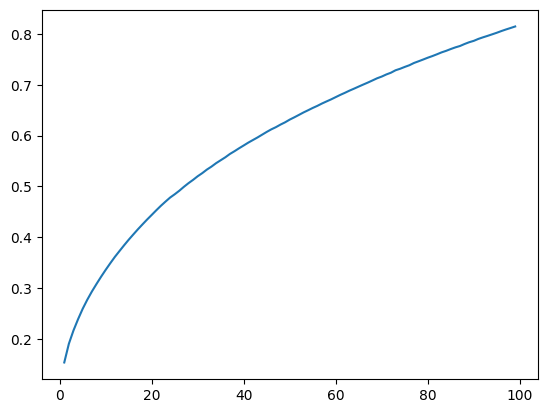

In [114]:
accuracies = []
for i in range(1,100):
    pca = PCA(n_components=i)
    pca.fit_transform(scaled_df)
    accuracies.append(sum(pca.explained_variance_ratio_))

plt.plot([i for i in range(1,100)], accuracies)